# Single and multi-sample Sparse FBA

This notebook reproduces the experiments for the multi-sample Sparse FBA in the manuscript. For an explanation, see also the min example in `sparseFBA_small_sim.ipynb` which explains the steps.

Numpy: 2.1.3



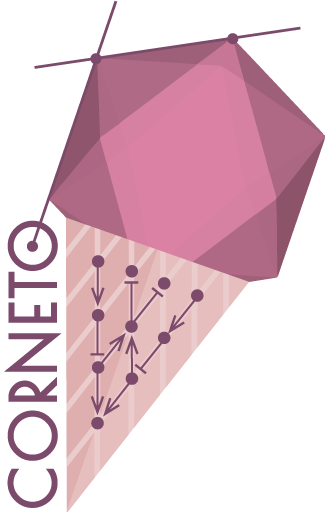

In [1]:
import corneto as cn
import numpy as np
import pandas as pd
from copy import deepcopy
import os

print("Numpy:", np.__version__)

cn.info()

In [2]:
solver = "GUROBI"
tol = 1e-6

In [3]:
G = cn.Graph.from_miom_model("https://github.com/pablormier/miom-gems/raw/refs/heads/main/gems/mitocore/v1.0.1/default.miom")
G.shape

(441, 555)

In [4]:
rxn_obj_id = next(G.get_edges_by_attr("id", "EX_biomass_e"))
rxn_obj_id

12

In [5]:
def corneto_fba(G, rxn_obj=None, min_flux=None, sparse=False):
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=1)
    F = P.expr.flow
    if sparse:
        P += cn.opt.Indicator(F)
        P.add_objectives(sum(P.expr._flow_i))
    if rxn_obj is not None:
        if isinstance(rxn_obj, str):
            rxn_obj = next(G.get_edges_by_attr("id", rxn_obj))
        if min_flux is not None:
            P += F[rxn_obj] >= min_flux
        P.add_objectives(-F[rxn_obj])
    return P

problem = corneto_fba(G, rxn_obj=rxn_obj_id)
problem.solve(solver=solver)
opt_flux = problem.expr.flow[rxn_obj_id].value
opt_flux

Set parameter Username
Set parameter LicenseID to value 2593994
Academic license - for non-commercial use only - expires 2025-12-02


np.float64(100.89230387215572)

In [6]:
len(np.flatnonzero(np.abs(problem.expr.flow.value)))

231

In [7]:
np.sum(np.abs(problem.expr.flow.value)>=1e-6)

np.int64(231)

In [8]:
problem = corneto_fba(G, rxn_obj=rxn_obj_id, min_flux=opt_flux, sparse=True)
problem.solve(solver=solver)
nrxns_min = np.sum(np.abs(problem.expr.flow.value)>=tol)
nrxns_min

np.int64(216)

In [9]:
if os.path.isfile('mitocore.csv'):
    df_ko_result = pd.read_csv('mitocore.csv').set_index('i')
    ko_result = [(r.i, r.id, r.opt_flux, r.min_rxn) for (_, r) in df_ko_result.reset_index().iterrows()]
    ko_result
else:
    ko_result = []
    for i in range(net.R.shape[0]):
        nkoi = do_ko(net, i)
        pf = corneto_flow(nkoi, rxn_obj=rxn_obj_id)
        pf.solve(solver=solver, verbosity=0)
        opt_ko_flux = pf.symbols['_flow'][rxn_obj_id].value
        pf = corneto_flow(nkoi, rxn_obj=rxn_obj_id, min_flux=opt_ko_flux, sparse=True)
        pf.solve(solver=solver, verbosity=0)
        print(i, net.R['id'][i], opt_ko_flux, pf.objectives[0].value)
        ko_result.append((i, net.R['id'][i], opt_ko_flux, pf.objectives[0].value))

In [10]:
# Simulations on MitoCore performing single KOs. This is done to find
# the reactions that have some impact on biomass production, as candidates for
# the multi-condition simulation
ko_result

[(0, 'EX_2hb_e', 100.89230387215594, 207.00004384651027),
 (1, 'EX_ac_e', 100.89230387215562, 207.00004380812305),
 (2, 'EX_acac_e', 100.80501513081464, 204.00004381517303),
 (3, 'EX_akg_e', 100.89230387215564, 207.0000438261111),
 (4, 'EX_ala_B_e', 100.89230387215557, 207.00004384011083),
 (5, 'EX_ala_L_e', 100.87799359723672, 205.00004374560567),
 (6, 'EX_arg_L_e', 100.87501109771534, 204.00000586641528),
 (7, 'EX_argsuc_e', 100.89230387215562, 207.00004380846),
 (8, 'EX_asn_L_e', 100.87529089453396, 204.0000438372241),
 (9, 'EX_asp_L_e', 100.62629856007646, 204.0000533105055),
 (10, 'EX_bhb_e', 100.8344159682852, 203.0000438310217),
 (11, 'EX_bilirub_e', 100.89230387215562, 207.00004387512104),
 (12, 'EX_biomass_e', 0.0, 0.0),
 (13, 'EX_but_e', 100.89230387215554, 207.00004380825368),
 (14, 'EX_chol_e', 100.89230387215564, 207.0000438228255),
 (15, 'EX_cit_e', 100.89230387215564, 207.0000438520879),
 (16, 'EX_citr_L_e', 100.89230387215564, 207.00004380846),
 (17, 'EX_co_e', 100.8923

In [11]:
intervention_obj_effect = {k_id: flux for k_id, _, flux, _ in ko_result}

In [12]:
# Show some interesting interventions
subset_interventions = []
for k_id, r_id, opt_ko_flux, n_rxns in ko_result:
    if abs(n_rxns - nrxns_min) > 10 and opt_ko_flux > 1e-3 and opt_ko_flux <= 0.999*opt_flux:
        print(k_id, r_id, opt_ko_flux, n_rxns)
        subset_interventions.append(k_id)

9 EX_asp_L_e 100.62629856007646 204.0000533105055
18 EX_co2_e 12.916868239866858 181.00004599129625
26 EX_glc_D_e 97.40185979214648 201.00004388426865
31 EX_h_e 99.341099932917 190.00004187440737
32 EX_h2o_e 84.27054152662792 177.0000607741228
35 EX_hdca_e 49.91050423765515 272.0000708135958
39 EX_lac_L_e 100.35230090215278 204.0000438790995
47 EX_nh4_e 100.4794679320681 129.0000019452489
49 EX_o2_e 1.846509909909828 102.00003696679973
74 HEX1 97.40185979214648 201.00004388426865
76 PGI 97.84603900999088 237.0000563006875
80 TPI 97.43093092183904 201.00004736414124
81 GAPD 97.38249779574096 192.00004383995991
82 PGK 97.38249779574096 192.00004383995991
88 LDH_L 100.35230090215278 204.0000438790995
97 PDHm 98.4927588944543 194.0000768734728
98 CSm 6.581457531655777 186.00006398705256
99 ACONTm 99.0374844711101 198.00006285265715
100 ICDHxm 95.94602724560954 197.00005630237197
106 MDHm 27.885252871451897 185.0000511933078
107 CI_MitoCore 69.89555499412448 174.00004743747257
108 CII_MitoC

In [13]:
len(subset_interventions)

48

Find a network with some characteristics (e.g production of biomass) and the networks for each intervention. Assumption is that each alt. network after intervention has min. distance wrt the control network.

In [14]:
def singlesparse_fba(G, interventions, obj_rxn=rxn_obj_id, opt_ko=None, prop_opt_ko=1.0, verbose=True):
    models = []
    S = np.zeros((G.shape[1], len(interventions)))
    F = np.zeros((G.shape[1], len(interventions)))
    for i, kid in enumerate(interventions):
        opt_flux = 0
        if opt_ko is not None:
            print(i, kid, prop_opt_ko * opt_ko[kid])
            opt_flux = prop_opt_ko*opt_ko[kid]
        pf = corneto_fba(G, rxn_obj=rxn_obj_id, min_flux=opt_flux, sparse=True)
        pf += pf.expr._flow_i[kid] == 0
        pf += pf.expr.flow[kid] == 0
        pf.solve(solver=solver, verbosity=int(verbose))
        S[:, i] = (np.abs(pf.expr.flow.value) >= tol).astype(int)
        F[:, i] = pf.expr.flow.value
        models.append(pf)
    return S, F

In [15]:
def multisparse_fba(G, interventions, obj_rxn=rxn_obj_id, alpha=1e-2, 
                    multi=True, opt_ko=None, prop_opt_ko=1.0, use_and=False, 
                    verbose=True, norel=0, time_limit=400, smodels=None, gap=0, min_or=False):
    # Maximize fba per intervention minimizing the distance across networks
    conditions = len(interventions)
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=conditions)
    P += cn.opt.Indicator(P.expr.flow)
    selected = []
    for i in range(conditions):
        F = P.expr._flow[:, i]
        sel = P.expr._flow_i[:, i]
        intv = interventions[i]
        # maximize biomass (if no info about opt ko)
        if opt_ko is None:
            P.add_objectives(-F[obj_rxn])
        else:
            print(f"Intervention: {intv}, FBA sol = {opt_ko[intv]}, FBA sol {prop_opt_ko*100}% = {prop_opt_ko * opt_ko[intv]}")
            #print(intv, prop_opt_ko * opt_ko[intv])
            P += F[obj_rxn] >= prop_opt_ko * opt_ko[intv]
        # Block flux on intervened reaction
        P += sel[intv] == 0 # blocked
        P += F[intv] == 0
        selected.append(sel)
        if not multi:
            P.add_objectives(sum(sel), weights=alpha)
    if alpha > 0:
        total = sum(selected)
        if min_or:
            # Old implementation
            logic_or = cn.K.Variable(name='_or', shape=total.shape, vartype=cn.VarType.BINARY)
            P += [
                # only 0 if total is 0
                logic_or >= total/conditions,
                logic_or <= total
            ]
            P.add_objectives(sum(logic_or), weights=alpha)
        else:
            P += cn.opt.linear_or(P.expr._flow_i, axis=1, varname="Y")
            P.add_objectives(sum(P.expr.Y), weights=alpha)
    warm_start = smodels != None    
    opt = {
        'IntegralityFocus': 1,
        'NoRelHeurTime': norel
    }
    if gap > 0:
        opt['MIPGap'] = gap
    P.solve(solver='GUROBI', verbosity=int(verbose), TimeLimit=time_limit, 
            warm_start=warm_start, **opt)
    return P, selected


## Experiments

Sparse FBA tries to find the smallest flux consistent metabolic network that is able to attain a particular objective. For multiple conditions, taking the union of one sparse FBA per condition do not achieve optimal results. Here we show how multi-condition sparse FBA can find better networks by integrating information from multiple conditions.

We show this first for a given set of interventions, assuming we know the optimal possible FBA solution per KO.

In [16]:
np.random.seed(42)
prop_opt_ko = 0.95
norel=100
norel=0
timelimit=350
verbose=False
reps=10
sizes = [2, 4, 8, 16]
gap=0.01

# Generate experiments
experiments = []
for size in sizes:
    for i in range(reps):
        sel_ids = np.random.choice(subset_interventions, size, replace=False)
        experiments.append((size, i, sel_ids))

df_experiments = pd.DataFrame(experiments, columns=["size", "rep", "intv_ids"])
df_experiments.to_csv("experiments.csv")
df_experiments

,size,rep,intv_ids
0,2,0,"[171, 483]"
1,2,1,"[485, 109]"
2,2,2,"[81, 485]"
3,2,3,"[482, 82]"
4,2,4,"[81, 97]"
5,2,5,"[440, 108]"
6,2,6,"[535, 74]"
7,2,7,"[170, 535]"
8,2,8,"[483, 440]"
9,2,9,"[35, 486]"


In [17]:
def run_experiments(experiments, prop_opt_ko=prop_opt_ko, alpha=1.0, gap=gap, min_or=False):
    results = []
    for i, r in experiments.iterrows():
        sel_ids = r.intv_ids
        print(f"k={r.size} (row {i}), selected interventions: {sel_ids}")
        print("- Running single...")
        Ns, Fs = singlesparse_fba(G, sel_ids, opt_ko=intervention_obj_effect, prop_opt_ko=prop_opt_ko, verbose=False)
        rxn_single = sum(np.mean(Ns, axis=1) > 0)
        print("- Running multi...")
        Mm = multisparse_fba(G, sel_ids, alpha=alpha, multi=True, verbose=verbose, norel=norel, min_or=min_or,
                             time_limit=timelimit, opt_ko=intervention_obj_effect, prop_opt_ko=prop_opt_ko, gap=gap)
        Nm = (np.abs(Mm[0].expr.flow.value) >= tol).astype(int)
        Fm = Mm[0].expr.flow.value
        rxn_multi = sum(np.mean(Nm, axis=1) > 0)
        results.append((i, Ns, Fs, Nm, Fm, rxn_single, rxn_multi))
        print("Multi-flux obj:", Fm[rxn_obj_id])
        print(f"N. conditions = {size}, Inferred network size: single={rxn_single}, multi={rxn_multi}")
    return results

In [18]:
def get_df_results(df_experiments, results):
    r_values = []
    for (i, r), res in zip(df_experiments.iterrows(), results):
        r_values.append((len(r.intv_ids), r.rep, res[-1], res[-2]))
    df = pd.DataFrame(r_values, columns=['size_interv', 'rep', 'multi', 'single'])
    return df

In [19]:
prop_opt_ko=0.50
results_50 = run_experiments(df_experiments, prop_opt_ko=prop_opt_ko)

k=3 (row 0), selected interventions: [171 483]
- Running single...
0 171 24.135253478952993
1 483 6.458434119933429
- Running multi...
Intervention: 171, FBA sol = 48.27050695790599, FBA sol 50.0% = 24.135253478952993
Intervention: 483, FBA sol = 12.916868239866858, FBA sol 50.0% = 6.458434119933429
Multi-flux obj: [24.13525348  6.45843412]
N. conditions = 16, Inferred network size: single=94, multi=89
k=3 (row 1), selected interventions: [485 109]
- Running single...
0 485 48.70092989607324
1 109 1.0513118622266553
- Running multi...
Intervention: 485, FBA sol = 97.40185979214648, FBA sol 50.0% = 48.70092989607324
Intervention: 109, FBA sol = 2.1026237244533106, FBA sol 50.0% = 1.0513118622266553
Multi-flux obj: [48.7009299   1.05131186]
N. conditions = 16, Inferred network size: single=80, multi=76
k=3 (row 2), selected interventions: [ 81 485]
- Running single...
0 81 48.69124889787048
1 485 48.70092989607324
- Running multi...
Intervention: 81, FBA sol = 97.38249779574096, FBA sol 

In [19]:
prop_opt_ko=0.90
results_90 = run_experiments(df_experiments, prop_opt_ko=prop_opt_ko)

k=3 (row 0), selected interventions: [171 483]
- Running single...
0 171 43.44345626211539
1 483 11.625181415880173
- Running multi...
Intervention: 171, FBA sol = 48.27050695790599, FBA sol 90.0% = 43.44345626211539
Intervention: 483, FBA sol = 12.916868239866858, FBA sol 90.0% = 11.625181415880173
Multi-flux obj: [43.44345626 11.62518142]
N. conditions = 16, Inferred network size: single=118, multi=118
k=3 (row 1), selected interventions: [485 109]
- Running single...
0 485 87.66167381293184
1 109 1.8923613520079796
- Running multi...
Intervention: 485, FBA sol = 97.40185979214648, FBA sol 90.0% = 87.66167381293184
Intervention: 109, FBA sol = 2.1026237244533106, FBA sol 90.0% = 1.8923613520079796
Multi-flux obj: [87.66167381  1.89236135]
N. conditions = 16, Inferred network size: single=98, multi=90
k=3 (row 2), selected interventions: [ 81 485]
- Running single...
0 81 87.64424801616687
1 485 87.66167381293184
- Running multi...
Intervention: 81, FBA sol = 97.38249779574096, FBA so

In [20]:
prop_opt_ko=0.10
results_10 = run_experiments(df_experiments, prop_opt_ko=prop_opt_ko)

k=3 (row 0), selected interventions: [171 483]
- Running single...
0 171 4.827050695790599
1 483 1.2916868239866859
- Running multi...
Intervention: 171, FBA sol = 48.27050695790599, FBA sol 10.0% = 4.827050695790599
Intervention: 483, FBA sol = 12.916868239866858, FBA sol 10.0% = 1.2916868239866859
Multi-flux obj: [4.8270507 1.8      ]
N. conditions = 16, Inferred network size: single=52, multi=47
k=3 (row 1), selected interventions: [485 109]
- Running single...
0 485 9.74018597921465
1 109 0.21026237244533108
- Running multi...
Intervention: 485, FBA sol = 97.40185979214648, FBA sol 10.0% = 9.74018597921465
Intervention: 109, FBA sol = 2.1026237244533106, FBA sol 10.0% = 0.21026237244533108
Multi-flux obj: [9.74018598 0.21026237]
N. conditions = 16, Inferred network size: single=80, multi=56
k=3 (row 2), selected interventions: [ 81 485]
- Running single...
0 81 9.738249779574097
1 485 9.74018597921465
- Running multi...
Intervention: 81, FBA sol = 97.38249779574096, FBA sol 10.0% =

In [22]:
def reduction(results):
    reductions = []
    for r in results:
        M = r[-1]
        S = r[-2]
        reduction = ((S-M)/S)*100
        reductions.append(reduction)
    return np.mean(reductions)

reduction(results_90), reduction(results_10)

(np.float64(5.789587923519852), np.float64(24.538723161318313))

In [20]:
import pickle

with open("results_50.pkl", "wb") as file:
    pickle.dump(results_50, file)

with open("results_90.pkl", "wb") as file:
    pickle.dump(results_90, file)

with open("results_10.pkl", "wb") as file:
    pickle.dump(results_10, file)